<a href="https://colab.research.google.com/github/saulolks/CDSentimentAnalysis-Project/blob/master/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/




---



In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.layers import Dense, Input, Flatten, Reshape, concatenate, Dropout
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.backend import reshape
from keras import optimizers
from keras import regularizers

from sklearn.model_selection import KFold

## Modelo Yoon Kim

Modelo original de **Yoon Kim** [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882)

Implementação [Jverma/cnn-text-classification-keras
](https://github.com/Jverma/cnn-text-classification-keras)

*   **EMBEDDING_DIM**: Dimension of the embedding space.
*   **MAX_SEQUENCE_LENGTH:** Maximum length of the sentence.
*   **MAX_NB_WORDS:** Maximum number of words in the vocabulary.
*   **embeddings_index:** A dict containing words and their embeddings.
*   **word_index:** A dict containing words and their indices.
*   **labels_index**: A dict containing the labels and their indices.
*   **fname**: Path to the file containing Google word2vecs.

In [0]:
datafolder = 'drive/My Drive/Colab Notebooks/MT/imdb_dataSet_k.csv'

In [0]:
MAX_SEQUENCE_LENGTH = 6118
MAX_NB_WORDS = 10000
EMBEDDING_DIM = 300
VALIDATION_SPLIT = 0.2
fname = 'drive/My Drive/UFRPE/'

### Funções

In [0]:
def prepareDataSet(datapath):
    #Shuffle
    data = pd.read_csv(datapath) 
    data = data.sample(frac=1)
    return data

In [0]:
data = prepareDataSet(datafolder)

In [0]:
num_words = len(data.columns)-2

In [0]:
X = data.iloc[:,2:len(data.columns)-1]
Y = data["class"]

### Modelo teste

In [0]:
def create_conv_model(vocabulary_size):
    model_conv = Sequential()
    model_conv.add(Embedding(vocabulary_size, 100, input_length=None))
    model_conv.add(Dropout(0.2))
    model_conv.add(Conv1D(64, 5, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=4))
    model_conv.add(LSTM(100))
    model_conv.add(Dense(1, activation='sigmoid'))
    model_conv.compile(loss='binary_crossentropy', optimizer='adam',    metrics=['accuracy'])
    
    return model_conv

In [0]:
model_conv = create_conv_model(num_words)

In [71]:
kf = KFold(n_splits=10, shuffle=False)
for train_index, test_index in kf.split(X):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    model_conv.fit(x=x_train, y=y_train, batch_size=50, validation_split=0.2,
                   epochs = 3)
    break

Epoch 1/3
990/990 [==============================] - 71s 72ms/step - loss: 0.6946 - acc: 0.4980
Epoch 2/3
990/990 [==============================] - 70s 70ms/step - loss: 0.6931 - acc: 0.5101
Epoch 3/3
990/990 [==============================] - 70s 71ms/step - loss: 0.6936 - acc: 0.5020


### Modelo

In [0]:
embedding_layer = Embedding(num_words, EMBEDDING_DIM)

In [0]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

# add first conv filter
embedded_sequences = Reshape((MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, 1))(embedded_sequences)
x = Conv2D(100, (5, EMBEDDING_DIM), activation='relu')(embedded_sequences)
x = MaxPooling2D((MAX_SEQUENCE_LENGTH - 5 + 1, 1))(x)


# add second conv filter.
y = Conv2D(100, (4, EMBEDDING_DIM), activation='relu')(embedded_sequences)
y = MaxPooling2D((MAX_SEQUENCE_LENGTH - 4 + 1, 1))(y)


# add third conv filter.
z = Conv2D(100, (3, EMBEDDING_DIM), activation='relu')(embedded_sequences)
z = MaxPooling2D((MAX_SEQUENCE_LENGTH - 3 + 1, 1))(z)


# concate the conv layers
alpha = concatenate([x,y,z])

# flatted the pooled features.
alpha = Flatten()(alpha)

# dropout
alpha = Dropout(0.5)(alpha)

# predictions
preds = Dense(1, activation='softmax')(alpha)

# build model
model = Model(sequence_input, preds)

In [0]:
adadelta = optimizers.Adadelta()
adam = optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, 
                       decay=0.0, amsgrad=False)

model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['acc'])

In [79]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 6118)         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 6118, 300)    1835700     input_8[0][0]                    
__________________________________________________________________________________________________
reshape_8 (Reshape)             (None, 6118, 300, 1) 0           embedding_6[5][0]                
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 6114, 1, 100) 150100      reshape_8[0][0]                  
__________________________________________________________________________________________________
conv2d_23 

### Treinamento

In [81]:
kf = KFold(n_splits=3, shuffle=False)
cont = 1
training_total = []

for train_index, test_index in kf.split(X):
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
   
    checkpointer = ModelCheckpoint(filepath='drive/My Drive/Colab Notebooks/MT/'
                                   'weights_k' + str(cont) + '.hdf5', 
                                   verbose=1, save_best_only=True)
    
    cont += 1
    
    training = model.fit(x=x_train, y=y_train, batch_size=50, 
                         validation_split=0.2, callbacks=[checkpointer], 
                         epochs=30)
    training_total.append(training)
    
    print('===================================================================='
          '==================================================================')

Train on 586 samples, validate on 147 samples
Epoch 1/30
586/586 [==============================] - 23s 39ms/step - loss: 8.1344 - acc: 0.4898 - val_loss: 8.1339 - val_acc: 0.4898

Epoch 00001: val_loss improved from inf to 8.13387, saving model to drive/My Drive/Colab Notebooks/MT/weights_k1.hdf5
Epoch 2/30
586/586 [==============================] - 21s 37ms/step - loss: 8.1344 - acc: 0.4898 - val_loss: 8.1339 - val_acc: 0.4898

Epoch 00002: val_loss did not improve from 8.13387
Epoch 3/30
150/586 [======>.......................] - ETA: 15s - loss: 8.0775 - acc: 0.4933

KeyboardInterrupt: ignored

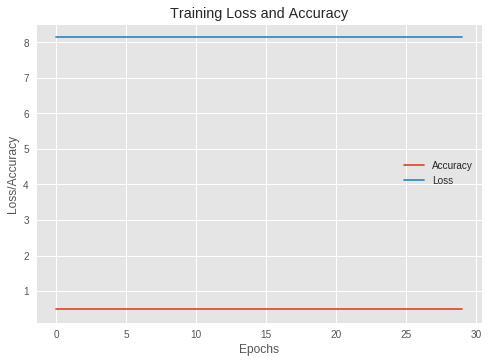

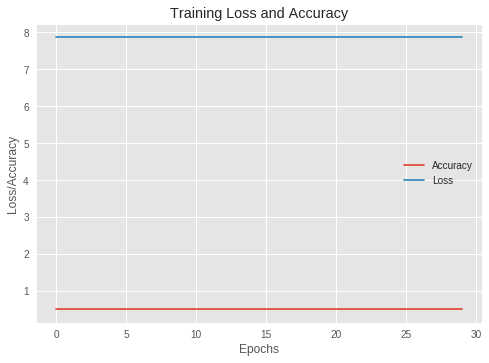

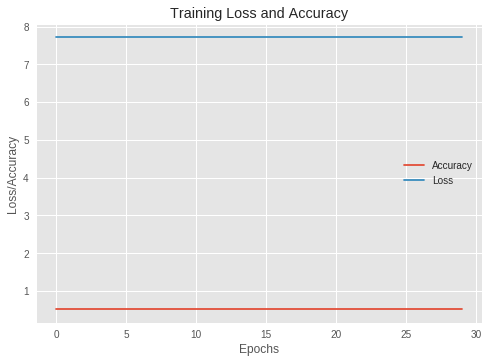

In [66]:
for i, training in enumerate(training_total):
  # plotar loss e accuracy para os datasets 'train' e 'test'
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(training.history['acc'], label='Accuracy')
  plt.plot(training.history['loss'], label='Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title("Training Loss and Accuracy")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.savefig('drive/My Drive/Colab Notebooks/MT/Treino-K' + str(i+1) + 
              '.png', bbox_inches='tight')